# 1. Initialize Environment and Dependencies
Set up libraries, visuals, and reproducibility controls before running the CFR experiments.

In [16]:
# Core scientific stack
import math
import time
import datetime as dt
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from mathematics_of_poker.games.ch11.clairvoyance import ClairvoyanceGame

plt.style.use("seaborn-v0_8")
RNG_SEED = 2025
np.random.seed(RNG_SEED)
plt.rcParams.update({
    "figure.figsize": (8, 4.5),
    "axes.grid": True,
    "grid.alpha": 0.25,
})

# 2. Define Experiment Configuration
Capture knobs for the Clairvoyance CFR sweep so we can adjust iterations, repeats, and payoff parameters centrally.

In [17]:
@dataclass
class ExperimentConfig:
    iterations: List[int]
    repeats: int
    pot_size: float
    bet_size: float
    base_seed: int
CONFIG = ExperimentConfig(
    iterations=[50, 150, 300, 600, 1200, 2400, 4800],
    repeats=3,
    pot_size=1.0,
    bet_size=1.0,
    base_seed=RNG_SEED,
 )
CONFIG

ExperimentConfig(iterations=[50, 150, 300, 600, 1200, 2400, 4800], repeats=3, pot_size=1.0, bet_size=1.0, base_seed=2025)

# 3. Load or Synthesize Dataset
Generate the iteration grid that acts as our synthetic dataset of experiment checkpoints.

In [18]:
iteration_schedule = np.array(CONFIG.iterations, dtype=int)
schedule_df = pd.DataFrame({"iteration": iteration_schedule})
schedule_df

,iteration
0,50
1,150
2,300
3,600
4,1200
5,2400
6,4800


# 4. Implement Experiment Workflow
Create helpers that run Clairvoyance CFR under both standard and CFR+ updates for a given iteration count.

In [19]:
def run_cfr_once(iterations: int, use_cfr_plus: bool, seed: int) -> Dict[str, float]:
    """Run CFR or CFR+ for a single iteration target and return key metrics."""
    game = ClairvoyanceGame(pot_size=CONFIG.pot_size, bet_size=CONFIG.bet_size)
    start = time.perf_counter()
    result = game.solve_cfr_equilibrium(
        iterations=iterations,
        seed=seed,
        use_cfr_plus=use_cfr_plus,
    )
    elapsed = time.perf_counter() - start
    return {
        "iterations": iterations,
        "use_cfr_plus": use_cfr_plus,
        "call_probability": float(result["x_strategy"][1]),
        "bluff_fraction": float(result["y_strategy"][2] + result["y_strategy"][3]),
        "game_value": float(result["game_value"]),
        "elapsed_seconds": elapsed,
    }

# 5. Execute Parameter Sweep
Run the experiment over the iteration schedule for both CFR variants and aggregate raw metrics.

In [20]:
records: List[Dict[str, float]] = []
for idx, iterations in enumerate(iteration_schedule):
    for repeat in range(CONFIG.repeats):
        seed_offset = CONFIG.base_seed + idx * CONFIG.repeats + repeat
        for use_cfr_plus in (False, True):
            records.append(
                run_cfr_once(
                    iterations=iterations,
                    use_cfr_plus=use_cfr_plus,
                    seed=seed_offset,
                )
            )
results_df = pd.DataFrame.from_records(records)
results_df.head()

,iterations,use_cfr_plus,call_probability,bluff_fraction,game_value,elapsed_seconds
0,50,False,0.596057,0.340872,0.331151,0.000662
1,50,True,0.716417,0.380472,0.307478,0.000534
2,50,False,0.596057,0.340872,0.331151,0.000573
3,50,True,0.716417,0.380472,0.307478,0.000554
4,50,False,0.596057,0.340872,0.331151,0.000487


# 6. Analyze Metrics and Visualize
Aggregate the sweep results, compute summary statistics, and plot convergence of call probability.

,use_cfr_plus,iterations,call_mean,call_std,value_mean,elapsed_mean
0,False,50,0.596057,0.0,0.331151,0.000574
1,False,150,0.710448,0.0,0.329501,0.001405
2,False,300,0.663835,0.0,0.332675,0.002926
3,False,600,0.660907,0.0,0.332923,0.005841
4,False,1200,0.682650,0.0,0.333361,0.012006
5,False,2400,0.674299,0.0,0.333341,0.022835
6,False,4800,0.676787,0.0,0.333223,0.045724
7,True,50,0.716417,0.0,0.307478,0.000537
8,True,150,0.686103,0.0,0.320138,0.001539
9,True,300,0.683225,0.0,0.324337,0.003390


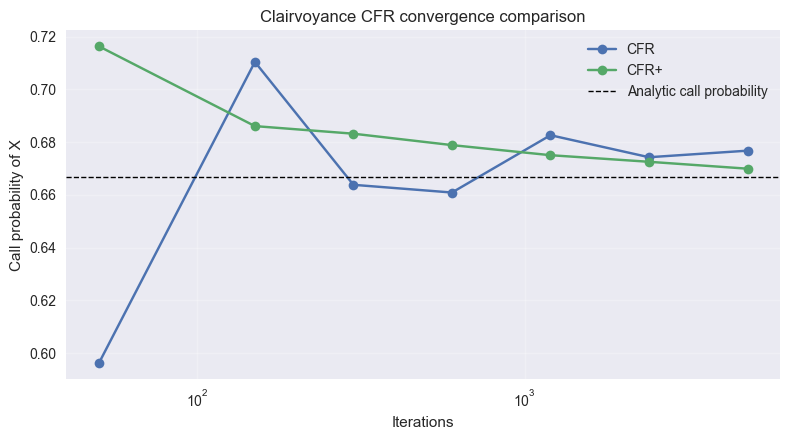

In [21]:
summary_df = (
    results_df
    .groupby(["use_cfr_plus", "iterations"])
    .agg(
        call_mean=("call_probability", "mean"),
        call_std=("call_probability", "std"),
        value_mean=("game_value", "mean"),
        elapsed_mean=("elapsed_seconds", "mean"),
    )
    .reset_index()
)
equilibrium_call = (2 * CONFIG.pot_size) / (2 * CONFIG.pot_size + CONFIG.bet_size)
fig, ax = plt.subplots()
for use_cfr_plus, data in summary_df.groupby("use_cfr_plus"):
    label = "CFR+" if use_cfr_plus else "CFR"
    ax.plot(
        data["iterations"],
        data["call_mean"],
        marker="o",
        label=label,
    )
ax.axhline(equilibrium_call, color="black", linestyle="--", linewidth=1, label="Analytic call probability")
ax.set_xscale("log")
ax.set_xlabel("Iterations")
ax.set_ylabel("Call probability of X")
ax.set_title("Clairvoyance CFR convergence comparison")
ax.legend(loc="best")
fig.tight_layout()
summary_df

# 7. Persist Artifacts
Store the aggregated metrics and the comparison chart for future reference.

In [22]:
artifacts_root = PROJECT_ROOT / "notebooks" / "artifacts"
timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = artifacts_root / f"clairvoyance_cfr_{timestamp}"
run_dir.mkdir(parents=True, exist_ok=True)
metrics_path = run_dir / "summary_metrics.csv"
plot_path = run_dir / "call_probability.png"
summary_df.to_csv(metrics_path, index=False)
fig.savefig(plot_path, dpi=200)
run_dir

WindowsPath('C:/Users/normh/OneDrive/dev/python/mathematics-of-poker/notebooks/artifacts/clairvoyance_cfr_20251212_141720')

# 8. Validate Experiment Outcomes
Run sanity checks to confirm CFR+ converges at least as fast as vanilla CFR across the sampled checkpoints.

In [23]:
wide_calls = summary_df.pivot(index="iterations", columns="use_cfr_plus", values="call_mean")
assert not wide_calls.empty, "Summary dataframe should not be empty."
assert False in wide_calls.columns and True in wide_calls.columns
max_abs_error_cfr = np.abs(wide_calls[False] - equilibrium_call).max()
max_abs_error_cfr_plus = np.abs(wide_calls[True] - equilibrium_call).max()
assert max_abs_error_cfr_plus <= max_abs_error_cfr + 1e-3
{
    "max_abs_error_cfr": float(max_abs_error_cfr),
    "max_abs_error_cfr_plus": float(max_abs_error_cfr_plus),
    "artifacts_dir": str(run_dir),
}

{'max_abs_error_cfr': 0.07060919048713621,
 'max_abs_error_cfr_plus': 0.049750082158869335,
 'artifacts_dir': 'C:\\Users\\normh\\OneDrive\\dev\\python\\mathematics-of-poker\\notebooks\\artifacts\\clairvoyance_cfr_20251212_141720'}